In [ ]:
# curl -o ~/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth https://download.pytorch.org/models/resnet18-f37072fd.pth

In [5]:
import os
from pathlib import Path
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [7]:
# Configs
image_size = 224
batch_size = 32

# Transformations (resize, normalize, etc.)
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # If grayscale; use 3 values if RGB
])

# Dataset path
data_dir = "data"

full_dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = full_dataset.classes
print("Classes:", class_names)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


Classes: ['0', '1', '2']


In [8]:
from torchvision.models import resnet18, ResNet18_Weights
import torch
import torch.nn as nn

# Load model without downloading weights
model = resnet18(weights=None)

# Load manually downloaded weights
state_dict = torch.load('/Users/sivaguganjayachandran/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth')
model.load_state_dict(state_dict)

# Modify the final layer
model.fc = nn.Linear(model.fc.in_features, 3)
model = model.to(device)

In [9]:
# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
# Evaluation function
def evaluate(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = 100 * correct / total
    return acc

In [12]:
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    val_acc = evaluate(model, val_loader)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss:.4f} - Val Accuracy: {val_acc:.2f}%")

Epoch 1/10 - Loss: 4.6665 - Val Accuracy: 72.76%
Epoch 2/10 - Loss: 4.5725 - Val Accuracy: 67.70%
Epoch 3/10 - Loss: 4.4315 - Val Accuracy: 75.88%
Epoch 4/10 - Loss: 4.1049 - Val Accuracy: 76.65%
Epoch 5/10 - Loss: 4.2461 - Val Accuracy: 73.93%
Epoch 6/10 - Loss: 3.4508 - Val Accuracy: 68.48%
Epoch 7/10 - Loss: 2.4450 - Val Accuracy: 75.10%
Epoch 8/10 - Loss: 3.7236 - Val Accuracy: 63.81%
Epoch 9/10 - Loss: 3.7433 - Val Accuracy: 63.42%
Epoch 10/10 - Loss: 3.8686 - Val Accuracy: 61.87%


In [15]:
# Save model
torch.save(model.state_dict(), "acne_model.pth")
print("Model saved to acne_model.pth")

Model saved to acne_model.pth



🧠 Predicted Acne Severity Level: 1


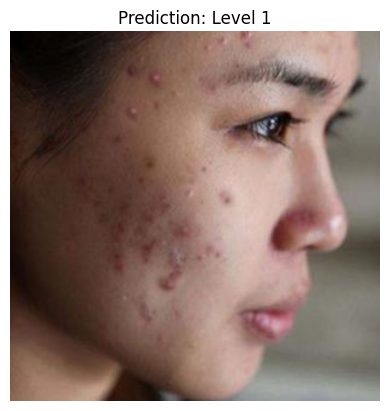

In [17]:
from PIL import Image

# Load the trained model (just to be safe, reload it fresh)
model.load_state_dict(torch.load("model/acne_model.pth"))
model.eval()

# Define a transform for the test image
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Prediction function
def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')
    img_tensor = test_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        _, predicted = torch.max(output, 1)

    print(f"\n🧠 Predicted Acne Severity Level: {class_names[predicted.item()]}")
    plt.imshow(image)
    plt.title(f"Prediction: Level {class_names[predicted.item()]}")
    plt.axis("off")
    plt.show()

# 👉 Replace this with your own image path
predict_image("data/1/levle1_18.jpg")

In [ ]:
model1 =

In [19]:
path = "data/0/levle0_1.jpg"

all the images are in data/0 data/1 data/2

read all the images in those directories and get their dimensions and plot it in plotly dark model

#reason for doing this is to fix on the crt size for reshaping the images regardless of their various size

SyntaxError: invalid syntax (4044302146.py, line 3)